<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [4]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [5]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


In [6]:
def EE(x, t, kappa,times = False):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")
    if times==True:
      return c, end_time - start_time
    else:
       return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [7]:
def CN(x, t, kappa, times = False):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")
    if times==True:
        return c, end_time - start_time
    else:
        return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

Finally, define some parameters and the x and t vectors:

In [8]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t_1000 = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [9]:
# Run the simulations
c_EE_1000 = EE(x, t_1000, kappa) # explicit Euler
c_CN_1000 = CN(x, t_1000, kappa) # Crank-Nicolson

/home/zhenya/miniconda3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/zhenya/miniconda3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

AttributeError: 'tuple' object has no attribute 'T'

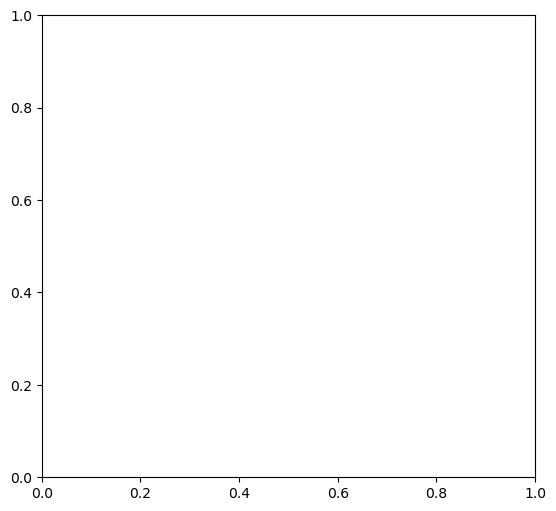

In [10]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t_1000, c_EE_1000.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t_1000, c_CN_1000.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

In [11]:
def changetime (Nt,Nx,kappa):

  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

  c_EE = EE(x, t, kappa) # explicit Euler
  c_CN = CN(x, t, kappa) # Crank-Nicolson

  plt.figure(figsize=(14, 6))

  plt.subplot(1, 2, 1)
  plt.pcolormesh(x, t, c_EE.T, shading='auto')
  plt.xlabel('x')
  plt.ylabel('t')
  plt.title('Explicit Euler')


  plt.subplot(1, 2, 2)
  plt.pcolormesh(x, t, c_CN.T, shading='auto')
  plt.xlabel('x')
  plt.ylabel('t')
  plt.title('Crank-Nicolson')

  plt.tight_layout()
 
  plt.show()
  plt.subplot(1, 2, 1)
  plt.colorbar()
  plt.plot(x,c_EE.T[0])
  plt.plot(x,c_EE.T[30])
  plt.subplot(1, 2, 2)
  plt.plot(x,c_CN.T[0])
  plt.plot(x,c_CN.T[30])
  plt.colorbar()
  return c_EE, c_CN

AttributeError: 'tuple' object has no attribute 'T'

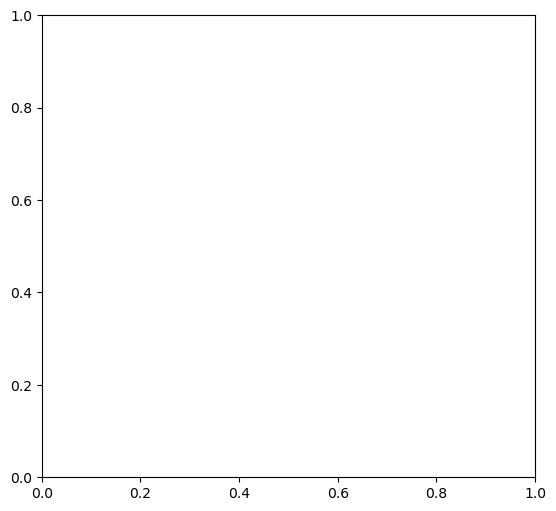

In [12]:
c_EE_10,c_CN_10 = changetime (1000,100,0.001)
c_EE_10,c_CN_10 = changetime (1000,1000,0.001)

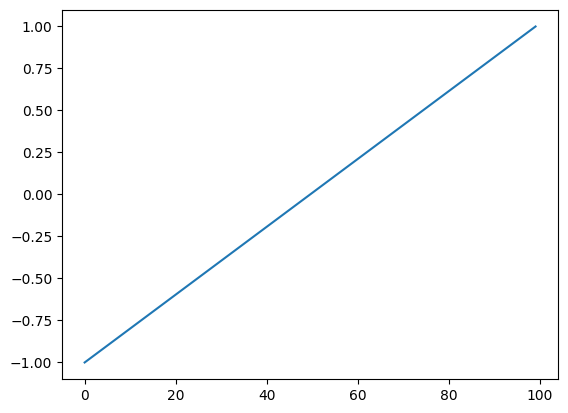

In [ ]:
plt.plot(x,)

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

At a large enough diffusivity, decreasing the time resolution makes the Euler method unstable. An explanation of the stability can be gained from the Euler method being first order with time, wheras the CN method finds the average of derivatives, hence being second-order in time. This means the Euler method reacts much slower to fast diffusion and hence blows up in error by creating larger and larger magnitude parcels of positive and negative concentration.




At constant timestep - the Euler method becomes unstable with increasing the number of spatial steps.

Hence, a stability field of the implicit Euler method can be found by taking locations in Nt and Nx space where the concentration doesn't become negative.


Ideas to think/ask
1.  Does an initially stable solution destabilize over a longer time?
2.  Contour Nt and Nx space for time at which it destabilizes




INSERT COMMENTS HERE

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [ ]:
# Add code to plot exact and numerical solutions
# Function to set the initial condition from the exact solution at time t_start

def exact(kappa,x,t_ic):
  c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
  return c_ic



In [ ]:
def changetimenoplot (Nt,Nx,kappa):

  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

  c_EE = EE(x, t, kappa) # explicit Euler
  c_CN = CN(x, t, kappa) # Crank-Nicolson


  return c_EE, c_CN

In [ ]:
def rmse(model,analytical):
  sq_diff = sum((model-analytical)**2)
  avg = sq_diff/len(model)
  return np.sqrt(avg)


In [ ]:
c_EE, c_CN = changetimenoplot(1000,int(400),0.001)


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

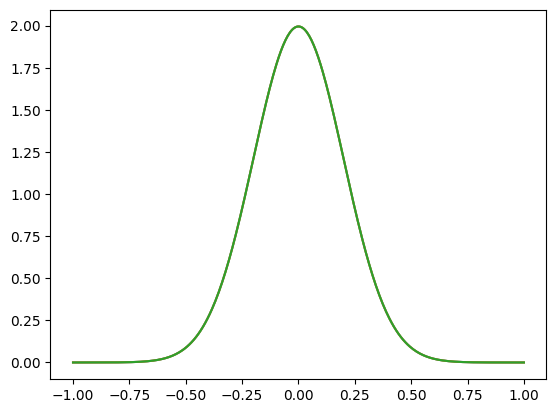

In [ ]:
x = np.linspace(-1,1, 400)  # Create a vector for x
analytic_sol = exact( 0.001, x,20)
plt.plot(x,c_EE.T[-1])
plt.plot(x,c_CN.T[-1])
plt.plot(x,analytic_sol)

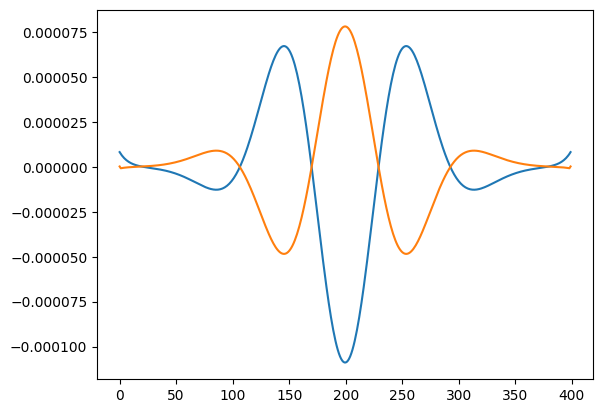

In [ ]:
#time
plt.plot(c_EE.T[-1]-analytic_sol)
plt.plot(c_CN.T[-1]-analytic_sol)


In [ ]:
print(c_EE.T[-1][0])
print(c_CN.T[-1][0])
print(analytic_sol[0])

1.5721160411851805e-05
7.717994327359533e-06
7.433597573671488e-06


In [ ]:
print(rmse(analytic_sol,c_EE.T[-1]))

rmse(analytic_sol,c_CN.T[-1])


3.91252153780976e-05


2.8106565515433122e-05

In [ ]:
errEE=[]
errCN =[]

for Nx in np.linspace(50,450,100):
  #print(Nt)
  c_EE, c_CN = changetimenoplot(1000,int(Nx),0.001)
  x = np.linspace(-1, 1,int(Nx))  # Create a vector for x

  analytic_sol = exact( 0.001,x, 20)
  errEE.append(rmse(analytic_sol,c_EE.T[-1]))

  errCN.append(rmse(analytic_sol,c_CN.T[-1]))


In [ ]:
print(errEE[-20])
print(errCN[-20])

3.489334451215866e-05
3.23339148966384e-05


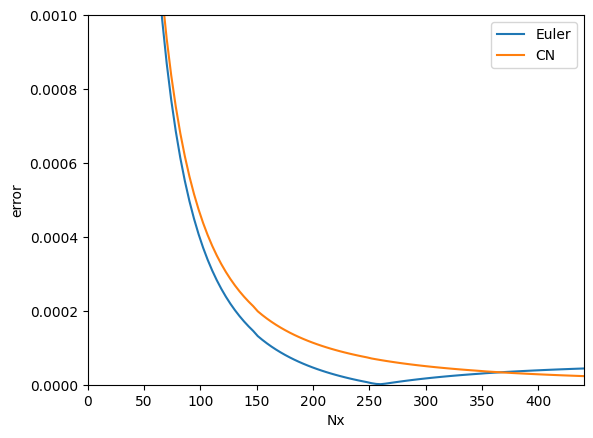

In [ ]:
plt.plot(np.linspace(50,450,100),errEE,label = 'Euler')
plt.plot(np.linspace(50,450,100),errCN, label = 'CN')
plt.xlabel('Nx')
plt.ylim(0,0.001)
plt.xlim(0,440)
plt.ylabel('error')
plt.legend()

In [ ]:
errEE=[]
errCN =[]
dictEE={}
dictCN={}
x = np.linspace(-1, 1, 100)  # Create a vector for x
analytic_sol = exact( 0.001,x, 20)
for Nt in np.linspace(100,1000,100):
  #print(Nt)
  c_EE, c_CN = changetimenoplot(int(Nt),100,0.001)


  errEE.append(rmse(analytic_sol,c_EE.T[-1]))

  errCN.append(rmse(analytic_sol,c_CN.T[-1]))


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


[]

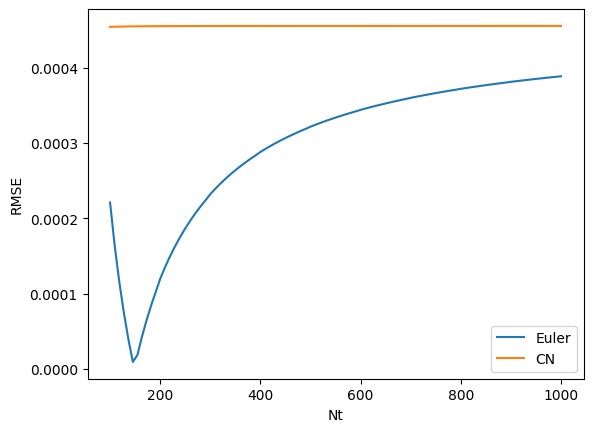

In [ ]:
plt.plot(np.linspace(100,1000,100),errEE,label = 'Euler')
plt.plot(np.linspace(100,1000,100),errCN,label = 'CN')
plt.xlabel('Nt')
plt.ylabel('RMSE')
plt.legend()
plt.plot()

KeyError: '100.0'

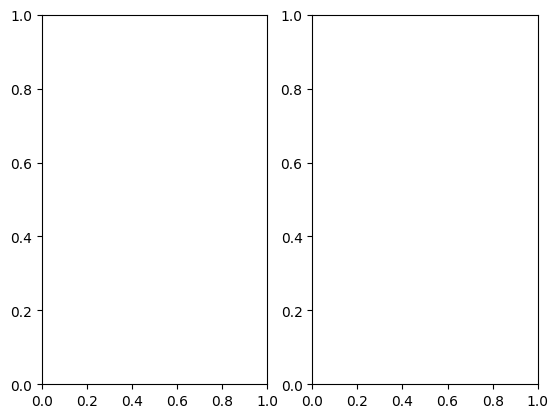

In [ ]:
for Nt in np.linspace(100,1000,10):
  fig,ax = plt.subplots(1,2)
  ax[0].plot(x,dictEE[str(Nt)])
  ax[0].plot(x,analytic_sol)
  plt.show()

In [ ]:
#plot error graphs through time
c_EE, c_CN = changetimenoplot(2000,100,0.001)
x= np.linspace(-1,1,100)
analytic_5s = exact( 0.001,x, 15)
analytic_10s = exact( 0.001,x, 20)

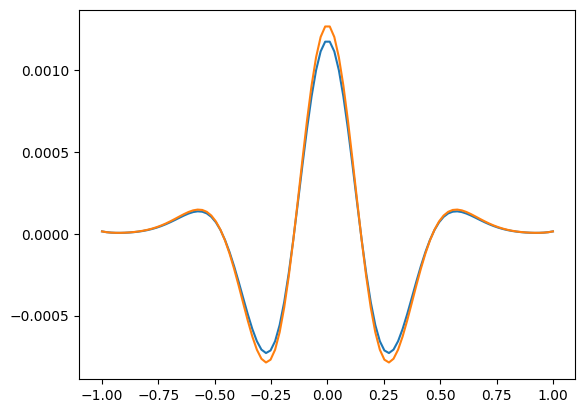

In [ ]:

plt.plot(x,c_EE.T[-1]-analytic_10s)
plt.plot(x,c_CN.T[-1]-analytic_10s)


In [ ]:
def returntime (Nt,Nx,kappa,tol):

  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  analytical = exact(kappa,x,20)
  #print(Nx,len(analytical))
  c_EE,t_EE = EE(x, t, kappa) # explicit Euler
  c_CN,t_CN = CN(x, t, kappa) # Crank-Nicolson
  rmse_EE = rmse(analytical,c_EE.T[-1])
  rmse_CN = rmse(analytical,c_CN.T[-1])
  nprmse = np.array([rmse_EE,rmse_CN])
  nprmse = np.where(nprmse>tol,np.nan,nprmse)
  return nprmse,t_EE,t_CN

DISCUSS DEFINITION OF ERROR

Error here is defined as the root mean square, comparing to the analytical solution.
${\color{red} NEEDS COMPLETING}$

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

In [ ]:
nprmse,t_EE,t_CN = returntime(100,100,0.001,0.0005)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [ ]:
Nts = np.linspace(100,1000,15)
Nxs = np.linspace(100,1000,15)
xx,yy = np.meshgrid(Nts,Nxs)
print(xx,yy)

[[ 100.          164.28571429  228.57142857  292.85714286  357.14285714
   421.42857143  485.71428571  550.          614.28571429  678.57142857
   742.85714286  807.14285714  871.42857143  935.71428571 1000.        ]
 [ 100.          164.28571429  228.57142857  292.85714286  357.14285714
   421.42857143  485.71428571  550.          614.28571429  678.57142857
   742.85714286  807.14285714  871.42857143  935.71428571 1000.        ]
 [ 100.          164.28571429  228.57142857  292.85714286  357.14285714
   421.42857143  485.71428571  550.          614.28571429  678.57142857
   742.85714286  807.14285714  871.42857143  935.71428571 1000.        ]
 [ 100.          164.28571429  228.57142857  292.85714286  357.14285714
   421.42857143  485.71428571  550.          614.28571429  678.57142857
   742.85714286  807.14285714  871.42857143  935.71428571 1000.        ]
 [ 100.          164.28571429  228.57142857  292.85714286  357.14285714
   421.42857143  485.71428571  550.          614.28571429  6

In [ ]:
Ntflat=np.ndarray.flatten(xx)
Nxflat = np.ndarray.flatten(yy)

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

In [ ]:
rmses_EE=[]
rmses_CN=[]
tsEE=[]
tsCN=[]
for i in range (len(Ntflat)):
  nprmse,t_EE,t_CN = returntime(int(Ntflat[i]),int(Nxflat[i]),0.001,0.001)
  rmses_EE.append(nprmse[0])
  rmses_CN.append(nprmse[1])
  tsEE.append(t_EE)
  tsCN.append(t_CN)
  print(t_EE,t_CN)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


0.016731739044189453 0.0705254077911377
0.015913963317871094 0.05036020278930664
0.02138686180114746 0.05263829231262207
0.027285337448120117 0.05956315994262695
0.03654956817626953 0.05556678771972656
0.027492761611938477 0.03671884536743164
0.053865671157836914 0.039223432540893555
0.0379335880279541 0.04025578498840332
0.04331493377685547 0.042958974838256836
0.051073551177978516 0.044515132904052734
0.04987001419067383 0.045464277267456055
0.05906319618225098 0.053344011306762695
0.06716012954711914 0.05262494087219238
0.061298370361328125 0.05558347702026367
0.0644071102142334 0.06081652641296387
0.009263277053833008 0.044234275817871094
0.011591672897338867 0.05109405517578125
0.01675105094909668 0.049773216247558594
0.020231962203979492 0.05449032783508301
0.024395227432250977 0.0630044937133789
0.03312802314758301 0.06249356269836426
0.03227877616882324 0.06643915176391602
0.03838920593261719 0.07144904136657715
0.03940725326538086 0.08583283424377441
0.04939985275268555 0.0808

<ipython-input-14-cba6af33872e>:2: RuntimeWarning: overflow encountered in square
  sq_diff = sum((model-analytical)**2)


0.028955698013305664 0.29369235038757324
0.022017717361450195 0.2124948501586914
0.10208821296691895 0.3620114326477051
0.051545143127441406 0.3688943386077881
0.038079261779785156 0.28043508529663086
0.08977460861206055 0.49396657943725586
0.08149957656860352 0.4390411376953125
0.08752655982971191 0.4730520248413086
0.09751057624816895 0.5249032974243164
0.10070490837097168 0.6000909805297852
0.1260998249053955 0.423001766204834
0.06777191162109375 0.47710371017456055
0.07979607582092285 0.5372865200042725
0.011775493621826172 0.16717219352722168
0.015763282775878906 0.20682740211486816
0.022708654403686523 0.2236342430114746
0.024394750595092773 0.24625086784362793
0.029504776000976562 0.27571725845336914
0.03476548194885254 0.30107808113098145
0.03851628303527832 0.4078850746154785
0.058457374572753906 0.43610453605651855
0.0612642765045166 0.4560837745666504
0.06426835060119629 0.5212063789367676
0.08961820602416992 0.5643889904022217
0.0900430679321289 0.6011629104614258
0.0650639

<ipython-input-29-96ae1b0d0b2b>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


0.042237043380737305 0.38469481468200684
0.04032015800476074 0.4159080982208252
0.04362678527832031 0.4465627670288086
0.05147290229797363 0.48122358322143555
0.049735307693481445 0.5209510326385498
0.061827898025512695 0.5672850608825684
0.06381773948669434 0.6515219211578369
0.06973958015441895 0.7396252155303955
0.07458949089050293 0.8379645347595215
0.07731342315673828 0.9681944847106934
0.0167543888092041 0.3104991912841797
0.02226996421813965 0.35264134407043457
0.02779364585876465 0.43604397773742676
0.038257598876953125 0.4743154048919678
0.04681658744812012 0.5362558364868164
0.05446028709411621 0.5428249835968018
0.044388771057128906 0.4943387508392334
0.04553031921386719 0.5152552127838135
0.0551300048828125 0.5711777210235596
0.05266284942626953 0.6133441925048828
0.05878710746765137 0.68892502784729
0.06571555137634277 0.837989091873169
0.06619095802307129 0.977092981338501
0.07633066177368164 1.1147661209106445
0.09075403213500977 1.6706349849700928
0.013277769088745117 0

In [ ]:
nprmses_EE = np.array(rmses_EE)
nptsEE=np.array(tsEE)

nprmses_CN = np.array(rmses_CN)
nptsCN=np.array(tsCN)

nptsEE = np.where(np.isnan(nprmses_EE)==True,np.nan,nptsEE)
nptsCN = np.where(np.isnan(nprmses_CN)==True,np.nan,nptsCN)



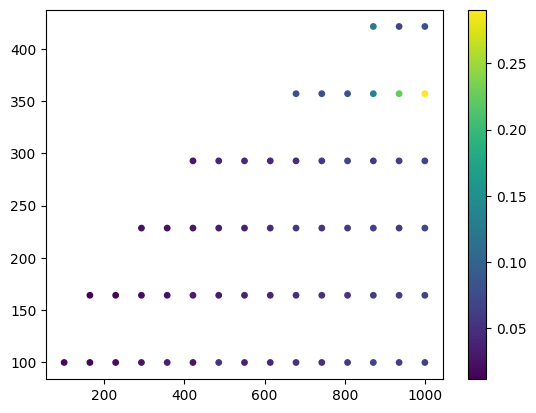

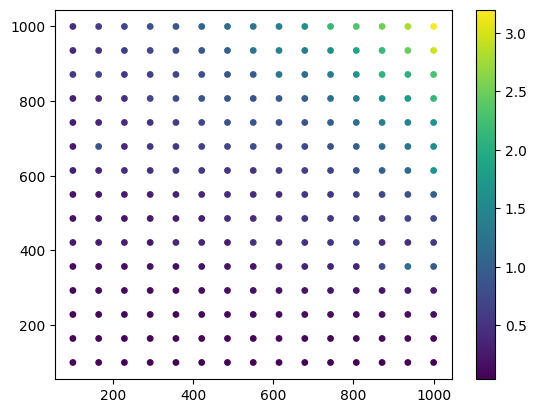

In [ ]:
plt.scatter(xx,yy,c = nptsEE.reshape([15,15]), s= 15)
plt.colorbar()
plt.show()

plt.scatter(xx,yy,c =nptsCN.reshape([15,15]), s=15 )
plt.colorbar()

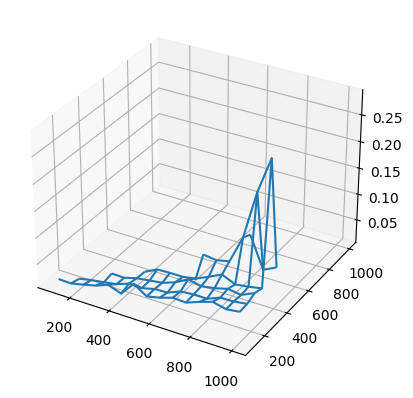

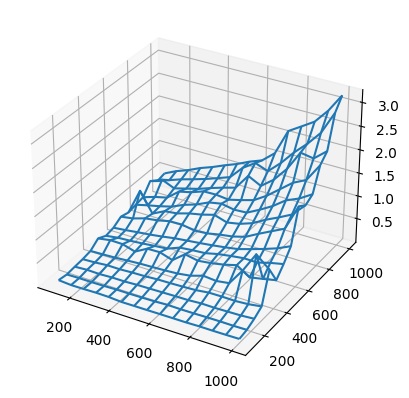

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(xx,yy,nptsEE.reshape([15,15]), rstride=1, cstride=1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(xx,yy,nptsCN.reshape([15,15]), rstride=1, cstride=1)


### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?